In [1]:
import sys
path_append = "../"
sys.path.append(path_append)  # Go up one directory from where you are.

In [2]:
import sklearn
sklearn.__version__

'1.1.0'

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
import numpy as np

from torch.utils.tensorboard import SummaryWriter

pd.options.mode.chained_assignment = None


# Feature Engineering

In [4]:
'''
    TRD_DD : Date
    ISU_CD : Stock Code
    ISU_NM : Stock Name
    TDD_CLSPRC : Closing Price
    TDD_OPNPRC : Opening Price
    TDD_HGPRC : High Price
    TDD_LWPRC : Low Price
    MKTCAP : Market Capitalization
    ACC_TRDVOL : Trading Volume
    EPS : Earnings Per Share
    PER : Price-Earnings Ratio
    BPS : Book Value Per Share
    PBR : Price-Book Ratio
    DPS : Dividends Per Share
    DVD_YLD : Dividend Yield

'''

'\n    TRD_DD : Date\n    ISU_CD : Stock Code\n    ISU_NM : Stock Name\n    TDD_CLSPRC : Closing Price\n    TDD_OPNPRC : Opening Price\n    TDD_HGPRC : High Price\n    TDD_LWPRC : Low Price\n    MKTCAP : Market Capitalization\n    ACC_TRDVOL : Trading Volume\n    EPS : Earnings Per Share\n    PER : Price-Earnings Ratio\n    BPS : Book Value Per Share\n    PBR : Price-Book Ratio\n    DPS : Dividends Per Share\n    DVD_YLD : Dividend Yield\n\n'

In [5]:
import os
import pandas as pd

# Loop through the first 3 files in the directory
for data_file in os.listdir(path_append + "../data/KR_Data/Data/")[:3]:
    data_file = data_file[:-4]  # Remove the file extension
    tmp_df = pd.read_csv(path_append + f"../data/KR_Data/Data/{data_file}.csv")
    
    # Display the first 3 rows of the dataframe
    print(f"Displaying first 3 rows of {data_file}.csv")
    display(tmp_df.head(3))


Displaying first 3 rows of HK0000057197.csv


,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2022/01/11,900110,이스트아시아홀딩스,145,150,151,143,"24,719,670,905","4,147,345",NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/10,900110,이스트아시아홀딩스,150,152,155,149,"25,572,073,350","2,628,028",NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/07,900110,이스트아시아홀딩스,151,158,162,148,"25,742,553,839","7,561,654",NaN,NaN,NaN,NaN,NaN,NaN


Displaying first 3 rows of HK0000214814.csv


,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2022/01/11,900270,헝셩그룹,460,481,482,456,"36,800,000,000","747,302",NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/10,900270,헝셩그룹,485,490,500,469,"38,800,000,000","852,598",NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/07,900270,헝셩그룹,485,513,537,478,"38,800,000,000","2,468,506",NaN,NaN,NaN,NaN,NaN,NaN


Displaying first 3 rows of HK0000295359.csv


,TRD_DD,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,PBR,DPS,DVD_YLD
0,2022/01/11,900260,로스웰,548,592,600,511,"98,725,730,764","58,874,006",NaN,NaN,NaN,NaN,NaN,NaN
1,2022/01/10,900260,로스웰,595,652,681,586,"107,193,083,585","47,913,246",NaN,NaN,NaN,NaN,NaN,NaN
2,2022/01/07,900260,로스웰,658,913,925,658,"118,542,939,494","171,463,169",NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import pandas as pd


# Read the data files
data_df = pd.read_csv(path_append + "../data/KR_Data/Data/HK0000057197.csv")
preprocessed_df = pd.read_csv(path_append + "../data/KR_Data/Preprocessed/HK0000057197_preprocessed.csv")

# Merge the DataFrames on the "TRD_DD" column
total_df = pd.merge(data_df, preprocessed_df, on="TRD_DD")



In [7]:
import pandas as pd

# Assuming total_df is already defined and merged from previous steps

# Reverse the DataFrame to sort dates from past to present
total_df = total_df[::-1].reset_index(drop=True)

# Split the "TRD_DD" column into year, month, and day columns
total_df[["Y", "M", "D"]] = total_df["TRD_DD"].str.split("/", expand=True)

# Drop the original "TRD_DD" column
total_df = total_df.drop("TRD_DD", axis=1)

# Rearrange columns to have year, month, and day first
total_df = total_df[["Y", "M", "D"] + total_df.columns[:-3].to_list()]


In [8]:
# Create a new 'Date' column by combining 'Y', 'M', 'D' columns
total_df['Date'] = pd.to_datetime(total_df[['Y', 'M', 'D']].rename(columns={'Y': 'year', 'M': 'month', 'D': 'day'}))

# Set 'Date' as the index
total_df.set_index('Date', inplace=True)

# Create a 'count_day' column that represents the number of days from the first date
total_df['count_day'] = (total_df.index - total_df.index.min()).days

# Drop the 'Y', 'M', 'Day' columns as they're no longer needed
total_df.drop(columns=['Y', 'M', 'D'], inplace=True)

# Reorder the columns to make 'count_day' first
cols = ['count_day'] + [col for col in total_df.columns if col != 'count_day']
total_df = total_df[cols]

total_df.head()

,count_day,ISU_CD,ISU_NM,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,...,BPS,PBR,DPS,DVD_YLD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-23,0,900110,동아체육용품,"3,825","4,500","4,500","3,825","87,975,000,000","6,399,130",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,NaN
2010-04-26,3,900110,동아체육용품,"3,860","3,655","4,055","3,650","88,780,000,000","4,312,630",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,1,1.000000
2010-04-27,4,900110,동아체육용품,"3,750","3,885","3,930","3,745","86,250,000,000","1,385,013",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.818182
2010-04-28,5,900110,동아체육용품,"3,700","3,700","3,970","3,660","85,100,000,000","1,422,838",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.636364
2010-04-29,6,900110,동아체육용품,"3,460","3,700","3,740","3,430","79,580,000,000","1,170,700",NaN,...,NaN,NaN,NaN,NaN,0,0,-1,1,0,0.454545


In [9]:
total_df.drop(['ISU_CD'], axis=1, inplace=True)


In [10]:
total_df["ISU_NM"] = total_df["ISU_NM"].astype(str)

# Create one-hot vectors
total_df = pd.get_dummies(total_df, columns=["ISU_NM"])


In [11]:
total_df

,count_day,TDD_CLSPRC,TDD_OPNPRC,TDD_HGPRC,TDD_LWPRC,MKTCAP,ACC_TRDVOL,EPS,PER,BPS,...,DVD_YLD,GDC_sig,RSI_sig,ROC_sig,MAP_sig,STC_sig,TREND,ISU_NM_동아체육용품,ISU_NM_이스트아시아스포츠,ISU_NM_이스트아시아홀딩스
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-23,0,"3,825","4,500","4,500","3,825","87,975,000,000","6,399,130",NaN,NaN,NaN,...,NaN,0,0,-1,1,0,NaN,True,False,False
2010-04-26,3,"3,860","3,655","4,055","3,650","88,780,000,000","4,312,630",NaN,NaN,NaN,...,NaN,0,0,-1,1,1,1.000000,True,False,False
2010-04-27,4,"3,750","3,885","3,930","3,745","86,250,000,000","1,385,013",NaN,NaN,NaN,...,NaN,0,0,-1,1,0,0.818182,True,False,False
2010-04-28,5,"3,700","3,700","3,970","3,660","85,100,000,000","1,422,838",NaN,NaN,NaN,...,NaN,0,0,-1,1,0,0.636364,True,False,False
2010-04-29,6,"3,460","3,700","3,740","3,430","79,580,000,000","1,170,700",NaN,NaN,NaN,...,NaN,0,0,-1,1,0,0.454545,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,4275,171,164,187,161,"29,152,163,619","29,419,967",NaN,NaN,NaN,...,NaN,0,0,-1,0,0,NaN,False,False,True
2022-01-06,4276,158,172,186,156,"26,935,917,262","22,931,278",NaN,NaN,NaN,...,NaN,0,0,0,0,0,NaN,False,False,True
2022-01-07,4277,151,158,162,148,"25,742,553,839","7,561,654",NaN,NaN,NaN,...,NaN,0,0,0,0,0,NaN,False,False,True


In [12]:
# Display non-NaN values of the columns to be dropped (for verification)
print("EPS non-NaN values:\n", total_df["EPS"].dropna())
print("PER non-NaN values:\n", total_df["PER"].dropna())
print("BPS non-NaN values:\n", total_df["BPS"].dropna())
print("PBR non-NaN values:\n", total_df["PBR"].dropna())
print("DPS non-NaN values:\n", total_df["DPS"].dropna())
print("DVD_YLD non-NaN values:\n", total_df["DVD_YLD"].dropna())

# Drop the unusable columns
total_df = total_df.drop(["EPS", "PER", "BPS", "PBR", "DPS", "DVD_YLD"], axis=1)

# Drop ISU_NM if it exists
if "ISU_NM" in total_df.columns:
    total_df = total_df.drop("ISU_NM", axis=1)
else:
    print("Column 'ISU_NM' not found in DataFrame")



EPS non-NaN values:
 Series([], Name: EPS, dtype: float64)
PER non-NaN values:
 Series([], Name: PER, dtype: float64)
BPS non-NaN values:
 Series([], Name: BPS, dtype: float64)
PBR non-NaN values:
 Series([], Name: PBR, dtype: float64)
DPS non-NaN values:
 Series([], Name: DPS, dtype: float64)
DVD_YLD non-NaN values:
 Series([], Name: DVD_YLD, dtype: float64)
Column 'ISU_NM' not found in DataFrame


In [13]:
import pandas as pd

# Example DataFrame setup (assuming total_df is already defined)
# total_df = ...

# List of columns to convert from strings to numeric values
columns_to_convert = ["TDD_CLSPRC", "TDD_OPNPRC", "TDD_HGPRC", "TDD_LWPRC", "MKTCAP", "ACC_TRDVOL"]

# Convert the columns to numeric values
for col in columns_to_convert:
    total_df[col] = total_df[col].str.replace(pat=r'[^0-9]', repl=r'' ,regex=True).apply(pd.to_numeric)



In [14]:
import pandas as pd

# Assuming total_df is already defined and filled with NaN values replaced by 0
# total_df = ...

# 1) Set TREND to 0 for any value that is not -1, 0, or 1
total_df.loc[~total_df["TREND"].isin([-1, 0, 1]), "TREND"] = 0

# 2) Set TREND to -1 for negative values and 1 for positive values
total_df.loc[total_df["TREND"] < 0, "TREND"] = -1
total_df.loc[total_df["TREND"] > 0, "TREND"] = 1

# 3) Adjust TREND values based on the specified conditions
total_df.loc[total_df["TREND"] <= -0.5, "TREND"] = -1
total_df.loc[total_df["TREND"] >= 0.5, "TREND"] = 1
total_df.loc[(total_df["TREND"] > -0.5) & (total_df["TREND"] < 0.5), "TREND"] = 0

# Check the unique values in the TREND column and their counts
unique_trends = set(total_df["TREND"])
trend_counts = total_df["TREND"].value_counts()

# Print the unique values and their counts
print("Unique TREND values:", unique_trends)
print("TREND value counts:\n", trend_counts)



Unique TREND values: {0.0, 1.0, -1.0}
TREND value counts:
 TREND
 0.0    2740
 1.0      76
-1.0      76
Name: count, dtype: int64


In [15]:
total_df["TREND"] += 1

In [16]:
total_df["TREND"] = total_df["TREND"].convert_dtypes(int)
total_df["TREND"]

Date
2010-04-23    1
2010-04-26    2
2010-04-27    1
2010-04-28    1
2010-04-29    1
             ..
2022-01-05    1
2022-01-06    1
2022-01-07    1
2022-01-10    1
2022-01-11    1
Name: TREND, Length: 2892, dtype: Int64

In [17]:
import pandas as pd

# Define the path to the preprocessed data file
file_path = path_append + "../data/KR_Data/Preprocessed/HK0000307485_preprocessed.csv"

# Read the preprocessed CSV file
tmp_df = pd.read_csv(file_path)

# Print the value counts for each of the specified columns
print("GDC_sig value counts:\n", tmp_df["GDC_sig"].value_counts())
print("\nRSI_sig value counts:\n", tmp_df["RSI_sig"].value_counts())
print("\nROC_sig value counts:\n", tmp_df["ROC_sig"].value_counts())
print("\nMAP_sig value counts:\n", tmp_df["MAP_sig"].value_counts())
print("\nSTC_sig value counts:\n", tmp_df["STC_sig"].value_counts())

GDC_sig value counts:
 GDC_sig
 0    1218
 1      33
-1      33
Name: count, dtype: int64

RSI_sig value counts:
 RSI_sig
 0    1241
 1      39
-1       4
Name: count, dtype: int64

ROC_sig value counts:
 ROC_sig
-1    942
 1    275
 0     67
Name: count, dtype: int64

MAP_sig value counts:
 MAP_sig
0    1284
Name: count, dtype: int64

STC_sig value counts:
 STC_sig
 0    1121
 1      97
-1      66
Name: count, dtype: int64


In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Assuming total_df is already defined and filled with NaN values replaced by 0
# total_df = ...

# Define the scalers
mm = MinMaxScaler()
sc = RobustScaler()

# Apply MinMax scaling to the specified columns
minmax_cols = ["count_day", "TDD_CLSPRC", "TDD_OPNPRC", "TDD_HGPRC", "TDD_LWPRC"]
for col in minmax_cols:
    total_df[col] = mm.fit_transform(total_df[col].values.reshape(-1, 1))

# Apply Robust scaling to the specified columns
robust_cols = ["MKTCAP", "ACC_TRDVOL"]
for col in robust_cols:
    total_df[col] = sc.fit_transform(total_df[col].values.reshape(-1, 1))


In [19]:
import pandas as pd
import plotly.graph_objects as go

# Assuming total_df is already defined and filled with NaN values replaced by 0
# total_df = ...

# Creating the figure
fig = go.Figure()

# Adding the line plot for MKTCAP
fig.add_trace(go.Scatter(x=total_df.index, y=total_df["MKTCAP"], mode='lines', name="stay"))

# Adding scatter plots for buy and sell points
fig.add_trace(go.Scatter(x=total_df[total_df["TREND"] < 0].index, y=total_df[total_df["TREND"] < 0]["MKTCAP"], mode="markers", name="buy", marker=dict(color='green')))
fig.add_trace(go.Scatter(x=total_df[total_df["TREND"] > 0].index, y=total_df[total_df["TREND"] > 0]["MKTCAP"], mode="markers", name="sell", marker=dict(color='red')))

# Updating layout
fig.update_layout(
    title='Stock Label',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Market Capitalization')
)

# Display the plot
fig.show()


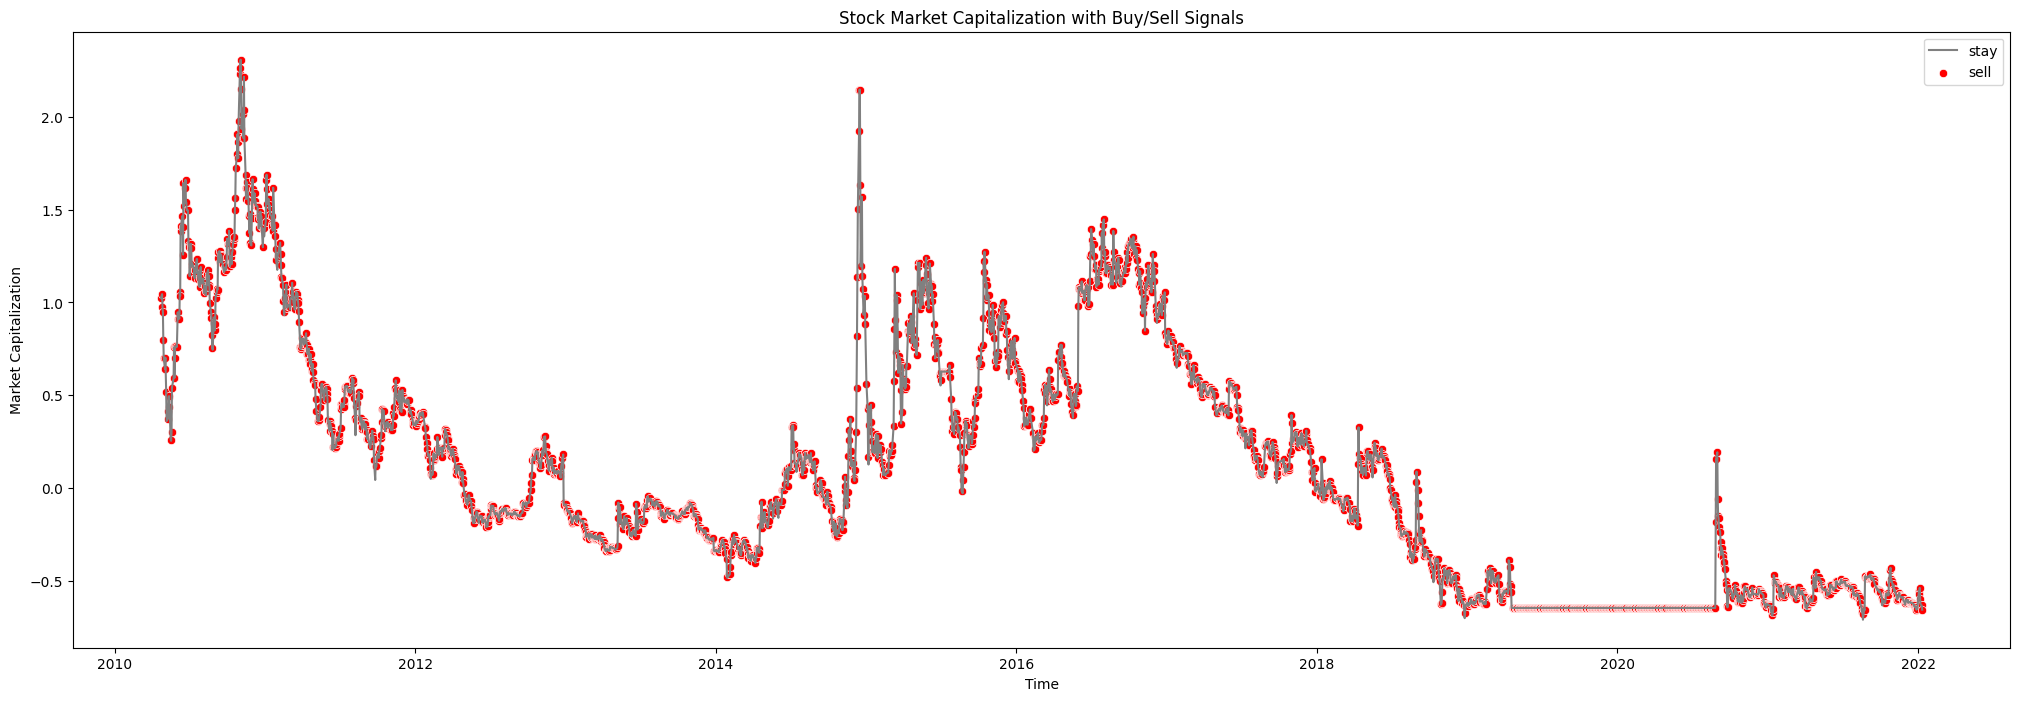

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming total_df is already defined
# total_df = ...

# Set the figure size
plt.figure(figsize=(25, 8))

# Plot the MKTCAP line
sns.lineplot(x=total_df.index, y=total_df["MKTCAP"], label="stay", color="gray")

# Plot the buy points (TREND < 0)
sns.scatterplot(x=total_df[total_df["TREND"] < 0].index, y=total_df[total_df["TREND"] < 0]["MKTCAP"], label="buy", color="blue")

# Plot the sell points (TREND > 0)
sns.scatterplot(x=total_df[total_df["TREND"] > 0].index, y=total_df[total_df["TREND"] > 0]["MKTCAP"], label="sell", color="red")

# Add titles and labels
plt.title('Stock Market Capitalization with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Market Capitalization')

# Show the plot
plt.legend()
plt.show()


# Data Overview and Usage Guide

In [21]:
# Data Overview and Usage Guide

"""
- Data Overview
    Preprocessed Data: total_df
    Categorical Columns: Y, M, D, ISU_CD, GDC_sig, RSI_sig, ROC_sig, MAP_sig, STC_sig
    Numerical Columns: TDD_CLSPRC, TDD_OPNPRC, TDD_HGPRC, TDD_LWPRC, MKTCAP, ACC_TRDVOL
    Label: TREND

- Considerations:
    1) It is recommended to use embedding techniques for categorical data.
    2) Labels:
        NaN values have been replaced with 0.

        2-1) Label Processing:
            How to handle -1, 0, 1 depends on the definition.
            ● Classification of -1, 0, 1:
                Commonly, the label being discrete is an issue.
                (1) Set to -1 for values less than 0, and 1 for values greater than 0.
                    # Ratio of -1, 0, 1 = 1397:1440:55
                    : This results in very frequent trading.

                (2) Use only -1, 0, 1.
                    # Ratio of -1, 0, 1 = 76:2740:76
                    : This might cause the model to miss buying opportunities when it should, making it difficult for the model to make accurate predictions.

                (3) Set to -1 for values less than -0.5, and 1 for values greater than 0.5, otherwise 0.
                    # Ratio of -1, 0, 1 = 752:1409:731
                    : (Current preprocessing state) This provides a somewhat balanced ratio.

            ● Regression:
                Keep the label as it is.
                (1) The model performs regression and decides whether to buy or sell based on the predicted increase or decrease.

    3) The utility of GDC, RSI, ROC, MAP, STC indicators for learning is uncertain.
"""


'\n- Data Overview\n    Preprocessed Data: total_df\n    Categorical Columns: Y, M, D, ISU_CD, GDC_sig, RSI_sig, ROC_sig, MAP_sig, STC_sig\n    Numerical Columns: TDD_CLSPRC, TDD_OPNPRC, TDD_HGPRC, TDD_LWPRC, MKTCAP, ACC_TRDVOL\n    Label: TREND\n\n- Considerations:\n    1) It is recommended to use embedding techniques for categorical data.\n    2) Labels:\n        NaN values have been replaced with 0.\n\n        2-1) Label Processing:\n            How to handle -1, 0, 1 depends on the definition.\n            ● Classification of -1, 0, 1:\n                Commonly, the label being discrete is an issue.\n                (1) Set to -1 for values less than 0, and 1 for values greater than 0.\n                    # Ratio of -1, 0, 1 = 1397:1440:55\n                    : This results in very frequent trading.\n\n                (2) Use only -1, 0, 1.\n                    # Ratio of -1, 0, 1 = 76:2740:76\n                    : This might cause the model to miss buying opportunities when it 

In [22]:
import torch
import random
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, batch_size):
        self.x = []
        self.y = []
        n_mul = len(x)//batch_size
        n_rest = len(x)%batch_size
        
        for i in range(n_mul):
            idx = int(i * n_mul)
            x_seq = torch.tensor(x[idx: idx+batch_size], dtype = torch.float32)
            y_seq = torch.tensor(y[idx: idx+batch_size], dtype = torch.float32)
            self.x.append(x_seq)
            self.y.append(y_seq)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [23]:
y = total_df[['TREND']]
X = total_df.drop(['TREND'],axis=1)


In [24]:
y

,TREND
Date,
2010-04-23,1
2010-04-26,2
2010-04-27,1
2010-04-28,1
2010-04-29,1
...,...
2022-01-05,1
2022-01-06,1
2022-01-07,1


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, shuffle= False)

In [26]:
X_train = X_train.iloc[:, :].values 
X_test = X_test.iloc[:, :].values 
y_train = y_train.iloc[:, -1].values
y_test = y_test.iloc[:, -1].values

In [27]:
len(X_train[0])

15